# Battle of Neighborhood - AirBNB Listing Data
Let's check if nearby venues of a listing affect price!

*Valentino Prasetya, 5 March 2021*

**Authors Note :**

This notebook is a part of my project in IBM Data Science Capstone Project. In this assignment, I am tasked to define a problem or idea where I can leverage using Foursquare location data to solve a problem. In choosing the business case, I recalled my experience not long ago where I am tasked to build a portfolio using AirBNB dataset. I decided to leverage my previous experience in handling Airbnb dataset using my new skill learnt in this course. Doing so increase my efficiency and give me the ability to measure my progress. Enjoy!

![Airbnb_Project2](https://news.airbnb.com/wp-content/uploads/sites/4/2018/03/accessible-header-wide-min.jpg?fit=1800%2C771)  

## Part 1

**Business Problem :**

Airbnb is a platform which connects people who want to rent out their property (hosts) with the people who are looking for a place to rent. One challenge that the hosts had when renting their property is determining the property price. If the price is too low, then they will loss potential profit. Otherwise, if price is set too high, then potential customer could be lost or lower customer satisfaction. 

In order to improve its profit, Airbnb has been collecting data about properties, hosts, and ratings given by customers. Two weeks ago, a data scientists were tasked to clean the data and build models to predict price using characteristic of the properties and customer ratings. Now, you were tasked to give insights about how the properties distributed spatially and see whether some spatial features affect pricing in a way.

**Goals :**

- Build a model to predict optimal price
- Give insight related to which variables are important in determining price

**Limitations**
- We only use a sample of 500 data in this project. Since, we are limited in resources of API calls.
- In order to give optimal price, we will need a price that is trusted. We will assume that a price is trusted to be optimal if there is at least a review. 
- There are a few most expensive listings which price is far higher than the rest of the listings. Due to the small number of these kind of data, we dropped the data.

**Terminology :**
- Host : Someone who want to rent their property
- Listing : The property that that is for sale or for rent (in this context, listing and property can be used interchangeably)
- Amenities : Useful features of a property

## Methodology

In my past project I had :
- Select usable features from the dataset
- Cleaned missing values and select reliable data
- Do EDA and detect outliers
- Prepare the data by labeling and encoding
- Try several machine learning algorithms and select best model
- Give insight to which feature is important in improving prices

In this notebook (Neighbourhood Battle Part 1), we will :
- Understand the data used in this project
- Do explanatory data analysis by visualizing distributions
- Do machine learning without location dataset
- Do visualization based on location of the data and check how it might affect the price of listings
- Scrape venues dataset using Foursquare API
- Preprocess the scraped data to extract useful features
- Add the preprocessed data to our current dataset
- Give insights based on the data

In the next notebook (Neighbourhood Battle Part 2), we will:
- Do machine learning to the combined dataset
- Compare the results
- Give conclusion and recommendation based on the results

## About the Data

The dataset was taken from [AirBNB Dataset](http://insideairbnb.com/get-the-data.html) taken in Singapore on June 25, 2019. The dataset used to have 96 features. During my previous project, I already cleaned the data and used several machine learning algorithms. For this project, I simplified the data using insights from previous session to extract useful features that I used in this project.

The dataset will contain features about property (listing) characteristics, including locations. My idea is using latitude and longitude variables in the dataset to generate surrounding venues. Generates insights based on these venues and finally check whether the features I generate can have an impact in listing prices. 

## Understanding the Data

Importing the Library

In [384]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
import folium

import requests

### Import the data

In [385]:
# Import Data
df = pd.read_csv("airbnb_simplified.csv")
df.head()

Unnamed: 0     id  price property_type     room_type  listing_duration  \
0           0  49091     81     Apartment  Private room               0.0   
1           1  50646     80     Apartment  Private room             252.0   
2           2  56334     68     Apartment  Private room            1559.0   
3           3  71609    200       Tourism  Private room            2575.0   
4           4  71896     92         House  Private room            2206.0   

   hosting_duration  calculated_host_listings_count  guests_included  \
0            1097.0                               2                1   
1            1570.0                               1                2   
2            1807.0                               2                1   
3            2899.0                               9                4   
4            2388.0                               9                1   

   extra_people  availability_365  availability_60  total_amenities  Pool  \
0            14               365               60               10     0   
1            20               365               60               14     1   
2            14               365               60               11     0   
3            27               353               51               27     0   
4            20               353               51               23     0   

   Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
0                    0      0   1          0               0   
1                    1      0   1          0               0   
2                    0      1   1          0               0   
3                    1      1   1          0               1   
4                    0      1   1          0               1   

   Free parking on premises  Paid parking on premises  Essentials  \
0                         0                         0           0   
1                         0                         0           1   
2                         0                         0           0   
3                         0                         0           1   
4                         0                         1           1   

   Pets allowed  Shampoo  Gym  Suitable for events  Free street parking  \
0             0        0    0                    0                    0   
1             0        1    1                    0                    0   
2             0        0    0                    0                    0   
3             0        1    0                    0                    1   
4             1        1    0                    0                    1   

   Laptop friendly workspace  minimum_nights  maximum_nights  \
0                          0             180             360   
1                          0              90             730   
2                          0               6              14   
3                          1               1            1125   
4                          0               1            1125   

  neighbourhood_group_cleansed  number_of_reviews_ltm  reviews_per_month  \
0                 North Region                      0               0.01   
1               Central Region                      0               0.28   
2                 North Region                      0               0.21   
3                  East Region                      2               0.13   
4                  East Region                      0               0.21   

   review_scores_location  review_scores_cleanliness  review_scores_accuracy  \
0                     8.0                       10.0                    10.0   
1                     9.0                       10.0                     9.0   
2                     8.0                       10.0                    10.0   
3                     8.0                        8.0                     8.0   
4                     8.0                        8.0                     8.0   

   review_scores_value  latitude  longitude  
0                  8.0  

In [386]:
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.set_index('id', drop=True)

In [387]:
df.shape

(4656, 37)

In [388]:
df.columns

Index(['price', 'property_type', 'room_type', 'listing_duration',
       'hosting_duration', 'calculated_host_listings_count', 'guests_included',
       'extra_people', 'availability_365', 'availability_60',
       'total_amenities', 'Pool', 'Family/kid friendly', 'Dryer', 'TV',
       'Breakfast', 'Smoke detector', 'Free parking on premises',
       'Paid parking on premises', 'Essentials', 'Pets allowed', 'Shampoo',
       'Gym', 'Suitable for events', 'Free street parking',
       'Laptop friendly workspace', 'minimum_nights', 'maximum_nights',
       'neighbourhood_group_cleansed', 'number_of_reviews_ltm',
       'reviews_per_month', 'review_scores_location',
       'review_scores_cleanliness', 'review_scores_accuracy',
       'review_scores_value', 'latitude', 'longitude'],
      dtype='object')

Dataset explanation :
- price : price of listing
- property_type : Type of property
- room_type : Type of room
- listing_duration : how long the listing has been posted
- hosting_duration : how long the host (renter) had joined AirBNB
- calculated_host_listing_count : number of listing the host had listed
- guests_included : whether the price had include guests
- extra_people : whether extra people are allowed
- availability_365, availability_60 : how much day among the next 365/60 days are available for booking
- total_amenities : number of amenities available
- pool, family/kid friendly, ..., laptop friendly workspace : useful amenities in the listing
- minimum_nights, maximum_nights : minimum and maximum nights required for booking
- neighbourhood_group_cleansed : neighbourhood group names
- number_of_reviews_ltm : number of review given to the listing
- reviews_per_month : number of reviews given per month
- reviews_scores_location, ..., review_scores_value : the score given to the listing for particular aspect
- latitude, longitude : coordinate of the listing

# Explanatory Data Analysis

A lot of EDA is done on outside the Lab (using Orange), example of important EDA will be listed here

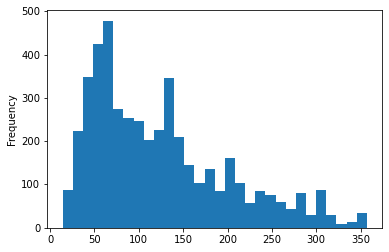

In [389]:
# Price
df['price'].plot(kind = 'hist', bins=30)
plt.show()

Price distribution is skewed to the left

[]

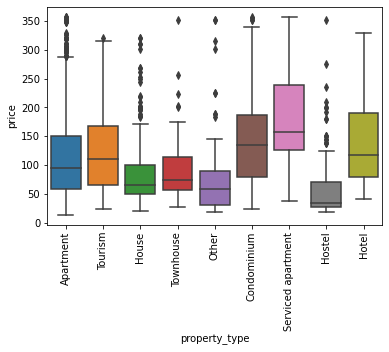

In [390]:
# Property type
sns.boxplot(x = 'property_type', y = 'price', data = df)
plt.xticks(rotation= 90)
plt.plot()

[]

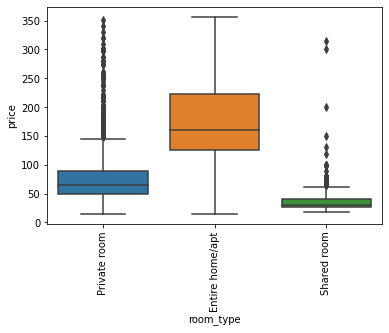

In [391]:
# Room type
sns.boxplot(x = 'room_type', y = 'price', data = df)
plt.xticks(rotation= 90)
plt.plot()

# Machine Learning

In [396]:
df2 = df.copy()

In [397]:
df2.dtypes[df2.dtypes == object]

property_type                   object
room_type                       object
neighbourhood_group_cleansed    object
dtype: object

In [398]:
dummy_variables = pd.get_dummies(df2[['neighbourhood_group_cleansed', 'property_type', 'room_type']])
df2 = pd.concat([df2, dummy_variables], axis=1)
df2.drop(['neighbourhood_group_cleansed', 'property_type', 'room_type'], axis=1, inplace = True)
df2.head()

price  listing_duration  hosting_duration  \
id                                                 
49091     81               0.0            1097.0   
50646     80             252.0            1570.0   
56334     68            1559.0            1807.0   
71609    200            2575.0            2899.0   
71896     92            2206.0            2388.0   

       calculated_host_listings_count  guests_included  extra_people  \
id                                                                     
49091                               2                1            14   
50646                               1                2            20   
56334                               2                1            14   
71609                               9                4            27   
71896                               9                1            20   

       availability_365  availability_60  total_amenities  Pool  \
id                                                                
49091               365               60               10     0   
50646               365               60               14     1   
56334               365               60               11     0   
71609               353               51               27     0   
71896               353               51               23     0   

       Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                 
49091                    0      0   1          0               0   
50646                    1      0   1          0               0   
56334                    0      1   1          0               0   
71609                    1      1   1          0               1   
71896                    0      1   1          0               1   

       Free parking on premises  Paid parking on premises  Essentials  \
id                                                                      
49091                         0                         0           0   
50646                         0                         0           1   
56334                         0                         0           0   
71609                         0                         0           1   
71896                         0                         1           1   

       Pets allowed  Shampoo  Gym  Suitable for events  Free street parking  \
id                                                                            
49091             0        0    0                    0                    0   
50646             0        1    1                    0                    0   
56334             0        0    0                    0                    0   
71609             0        1    0                    0                    1   
71896             1        1    0                    0                    1   

       Laptop friendly workspace  minimum_nights  maximum_nights  \
id                                                                 
49091                          0             180             360   
50646                          0              90             730   
56334                          0               6              14   
71609                          1               1            1125   
71896                          0               1            1125   

       number_of_reviews_ltm  reviews_per_month  review_scores_location  \
id                                                                        
49091                      0               0.01                     8.0   
50646                      0               0.28                     9.0   
56334                      0               0.21                     8.0   
71609                      2               0.13                     8.0   
71896                      0               0.21                     8.0   

       review_scores_cleanliness  review_scores_accuracy  review_scores_value  \
id                                      

In [399]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

y = df2['price'] # Target
X = df2.drop(['price', 'latitude', 'longitude'], axis = 1) # Predictors

# Standardize
scaler = StandardScaler()

X_train_o, X_test_o, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)

X_train = scaler.fit_transform(X_train_o)
X_test = scaler.transform(X_test_o)

In [400]:
# Random Forest Model (Previous project best model)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [401]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("rf score : {}".format(rf.score(X_test, y_test)))
print("rf test MSE : {}".format(mean_squared_error(rf.predict(X_test), y_test)))

rf score : 0.7632111635659782
rf test MSE : 1484.3407949892628


Using random forest regressor without location data, the r2 score of the model is 0.76, meaning the model able to predit 76% of the variance in price.

# Let's look at the location data

In [402]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Singapore')

singapore_coord = (location.latitude, location.longitude)
singapore_coord

(1.357107, 103.8194992)

In [403]:
df['neighbourhood_group_cleansed'].value_counts()

Central Region       3762
East Region           324
West Region           298
North-East Region     183
North Region           89
Name: neighbourhood_group_cleansed, dtype: int64

In [404]:
import folium

# create map of New York using latitude and longitude values
map_singapore = folium.Map(location=singapore_coord, zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['latitude'], df['longitude'], df['neighbourhood_group_cleansed']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

The map shows the distribution of listings in Singapore

# Sampling the dataset 

Foursquare API has limit of 950 API calls per day. Using entire dataset will result in error since the limit is exceeded (I tried..). So, for this purpose, we will limit our study to a sample of 500 data.

In [405]:
df = df.sample(500, random_state = 47)
df.head()

price       property_type        room_type  listing_duration  \
id                                                                       
26056791     56           Apartment     Private room             357.0   
25980709    250           Apartment  Entire home/apt               0.0   
11283882    301  Serviced apartment  Entire home/apt              45.0   
29307578    278         Condominium  Entire home/apt             237.0   
6352827      50           Apartment     Private room             839.0   

          hosting_duration  calculated_host_listings_count  guests_included  \
id                                                                            
26056791            2504.0                               9                1   
25980709             694.0                               6                4   
11283882             978.0                             193                4   
29307578             298.0                               5                5   
6352827             1498.0                              12                2   

          extra_people  availability_365  availability_60  total_amenities  \
id                                                                           
26056791             0               147               38               15   
25980709            30                 2                1               16   
11283882            30               201                4               31   
29307578            42               299               24               18   
6352827             25                75               44               14   

          Pool  Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                          
26056791     0                    0      0   0          0               0   
25980709     1                    0      0   1          0               0   
11283882     1                    1      1   1          0               1   
29307578     0                    0      1   1          0               0   
6352827      0                    1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights neighbourhood_group_cleansed  number_of_reviews_ltm  \
id                                                                             
26056791            1125               Central Region                     41   
25980709            1125               Central Region                      1   
11283882             800            

We will redo the machine learning steps and see what happens.

In [406]:
dummy_variables = pd.get_dummies(df[['neighbourhood_group_cleansed', 'property_type', 'room_type']])
df2 = pd.concat([df, dummy_variables], axis=1)
df2.drop(['neighbourhood_group_cleansed', 'property_type', 'room_type'], axis=1, inplace = True)
df2.head()

price  listing_duration  hosting_duration  \
id                                                    
26056791     56             357.0            2504.0   
25980709    250               0.0             694.0   
11283882    301              45.0             978.0   
29307578    278             237.0             298.0   
6352827      50             839.0            1498.0   

          calculated_host_listings_count  guests_included  extra_people  \
id                                                                        
26056791                               9                1             0   
25980709                               6                4            30   
11283882                             193                4            30   
29307578                               5                5            42   
6352827                               12                2            25   

          availability_365  availability_60  total_amenities  Pool  \
id                                                                   
26056791               147               38               15     0   
25980709                 2                1               16     1   
11283882               201                4               31     1   
29307578               299               24               18     0   
6352827                 75               44               14     0   

          Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                    
26056791                    0      0   0          0               0   
25980709                    0      0   1          0               0   
11283882                    1      1   1          0               1   
29307578                    0      1   1          0               0   
6352827                     1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights  number_of_reviews_ltm  reviews_per_month  \
id                                                                   
26056791            1125                     41               3.40   
25980709            1125                      1               0.21   
11283882             800                      0               0.05   
29307578            1125                     27               3.28   
6352827             1125                     39               3.33   

          review_scores_location  review_scores_cleanliness  \
id                                                           

In [407]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

y = df2['price'] # Target
X = df2.drop(['price', 'latitude', 'longitude'], axis = 1) # Predictors

# Standardize
scaler = StandardScaler()

X_train_o, X_test_o, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)

X_train = scaler.fit_transform(X_train_o)
X_test = scaler.transform(X_test_o)

In [408]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("rf score : {}".format(rf.score(X_test, y_test)))
print("rf test MSE : {}".format(mean_squared_error(rf.predict(X_test), y_test)))

rf score : 0.6182642510009551
rf test MSE : 2262.664324


Limiting the dataset to 500 samples dropped the score by a lot. From 76% to 62%. However, since our target is to see whether spatial features improve the accuracy, we will proceed to the next step.

# Scrape the Venues Dataset

Credential ID removed for privacy purpose

In [409]:
# Foursquare API

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210301' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [216]:
# Function to get venues (Already given in the previous exercise)

def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

listing_venues = getNearbyVenues(names=df.index.to_list(),
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

26056791
25980709
11283882
29307578
6352827
15751335
4990462
1183421
23015765
13068368
15751182
21703476
29016090
16620686
31599406
17228916
6481052
7015864
31218304
27879969
29970192
28415998
11496278
9979272
29136859
17231060
20769549
27271318
18859485
29355663
24360251
30033286
14390525
30163724
28232158
13070435
14524075
29469683
22019165
5186205
17410578
17868090
26261789
29412602
8345921
6697057
11515630
9519477
28877293
34564395
17097609
2029278
32945017
12987129
30281851
11443262
19800389
29134069
30971262
34052197
33669171
10440979
24705997
31107733
8143933
330094
8264717
29106981
17801220
29245382
29081996
26555143
14987419
20877576
3179080
8445747
2009008
24706634
23870581
9786807
12365867
32503412
5024661
4138944
3212083
33393706
20743994
11282735
11714703
20291676
24124445
9927724
21069270
30570881
13839454
18724523
34193239
15441196
23870306
27381380
29743848
23150443
19801615
30171849
21234121
34001411
15000577
9835116
9359194
2488042
20936240
23952759
17416854
32344101


In [410]:
listing_venues

Unnamed: 0  Neighborhood  Neighborhood Latitude  \
0               0      26056791                1.30495   
1               1      26056791                1.30495   
2               2      26056791                1.30495   
3               3      26056791                1.30495   
4               4      26056791                1.30495   
...           ...           ...                    ...   
23007       23007       8380826                1.34726   
23008       23008       8380826                1.34726   
23009       23009       8380826                1.34726   
23010       23010       8380826                1.34726   
23011       23011       8380826                1.34726   

       Neighborhood Longitude                         Venue  Venue Latitude  \
0                   103.86233        Tolido's Espresso Nook        1.304399   
1                   103.86233               呷三碗福利社 Eat3Bowl        1.304300   
2                   103.86233    Swimming Pool @ Hotel Boss        1.305803   
3                   103.86233                 The Projector        1.302255   
4                   103.86233               Toots Brasserie        1.303287   
...                       ...                           ...             ...   
23007               103.70083                        Subway        1.348425   
23008               103.70083                    McDonald's        1.348689   
23009               103.70083       Sheng Siong Supermarket        1.348990   
23010               103.70083           口福 KOUFU Food Court        1.349317   
23011               103.70083  Faith Family Clinic (Jurong)        1.348853   

       Venue Longitude        Venue Category  
0           103.860686                  Café  
1           103.860752  Taiwanese Restaurant  
2           103.860348                  Pool  
3           103.863553             Multiplex  
4           103.861117     French Restaurant  
...                ...                   ...  
23007       103.697866        Sandwich Place  
23008       103.697586  Fast Food Restaurant  
23009       103.703497           Supermarket  
23010       103.697395            Food Court  
23011       103.697552              Pharmacy  

[23012 rows x 8 columns]

In [411]:
listing_venues.shape

(23012, 8)

In [412]:
listing_venues.head()

Unnamed: 0  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0      26056791                1.30495               103.86233   
1           1      26056791                1.30495               103.86233   
2           2      26056791                1.30495               103.86233   
3           3      26056791                1.30495               103.86233   
4           4      26056791                1.30495               103.86233   

                        Venue  Venue Latitude  Venue Longitude  \
0      Tolido's Espresso Nook        1.304399       103.860686   
1             呷三碗福利社 Eat3Bowl        1.304300       103.860752   
2  Swimming Pool @ Hotel Boss        1.305803       103.860348   
3               The Projector        1.302255       103.863553   
4             Toots Brasserie        1.303287       103.861117   

         Venue Category  
0                  Café  
1  Taiwanese Restaurant  
2                  Pool  
3             Multiplex  
4     French Restaurant

In [413]:
# Check how many venues were returned for each neighborhood
listing_venues.groupby('Neighborhood').count()

Unnamed: 0  Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                              
330094                15                     15                      15   
423875                 9                      9                       9   
606784                 9                      9                       9   
1183421              100                    100                     100   
1244654               65                     65                      65   
...                  ...                    ...                     ...   
34358745              13                     13                      13   
34486779              44                     44                      44   
34564395              74                     74                      74   
34833594              50                     50                      50   
35237622              76                     76                      76   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
330094           15              15               15              15  
423875            9               9                9               9  
606784            9               9                9               9  
1183421         100             100              100             100  
1244654          65              65               65              65  
...             ...             ...              ...             ...  
34358745         13              13               13              13  
34486779         44              44               44              44  
34564395         74              74               74              74  
34833594         50              50               50              50  
35237622         76              76               76              76  

[500 rows x 7 columns]

In [414]:
print('There are {} uniques categories.'.format(len(listing_venues['Venue Category'].unique())))

There are 315 uniques categories.


Save the scraping result

In [415]:
listing_venues.to_csv('listing_venues.csv')

# Analyze Each Listing

In [416]:
listing_venues = pd.read_csv('listing_venues.csv')

In [417]:
# one hot encoding
listing_onehot = pd.get_dummies(listing_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
listing_onehot['Neighborhood'] = listing_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [listing_onehot.columns[-1]] + list(listing_onehot.columns[:-1])
listing_onehot = listing_onehot[fixed_columns]

listing_onehot.head()

Zhejiang Restaurant  Accessories Store  American Restaurant  Arcade  \
0                    0                  0                    0       0   
1                    0                  0                    0       0   
2                    0                  0                    0       0   
3                    0                  0                    0       0   
4                    0                  0                    0       0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Australian Restaurant  Auto Dealership  BBQ Joint  Badminton Court  \
0                      0                0          0                0   
1                      0                0          0                0   
2                      0                0          0                0   
3                      0                0          0                0   
4                      0                0          0                0   

   Bagel Shop  Bakery  Bar  Baseball Field  Baseball Stadium  \
0           0       0    0               0                 0   
1           0       0    0               0                 0   
2           0       0    0               0                 0   
3           0       0    0               0                 0   
4           0       0    0               0                 0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0      0                0         0            0   
1                 0      0                0         0            0   
2                 0      0                0         0            0   
3                 0      0                0         0            0   
4                 0      0                0         0            0   

   Belgian Restaurant  Betting Shop  Big Box Store  Bike Rental / Bike Share  \
0                   0             0              0                         0   
1                   0             0              0                         0   
2                   0             0              0                         0   
3                   0             0              0                         0   
4                   0             0              0                         0   

   Bike Shop  Bistro  Board Shop  Boarding House  Boat or Ferry  Bookstore  \
0          0       0           0               0              0          0   
1          0       0           0               0              0          0   
2          0       0           0               0              0          0   
3          0       0           0               0              0          0   
4          0       0           0               0              0          0   

   Boutique  Bowling Alley  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  \
0         0              0               0        0       0                0   
1         0              0               0        0       0                0   
2         0              0               0        0       0                0   
3         0              0               0        0       0                0   
4         0              0               0        0       0                0   

   Buddhist Temple  Buffet  Building  Bu

In [418]:
listing_onehot.shape

(23012, 315)

In [419]:
# Get number of venues in each listing id
listing_grouped = listing_onehot.groupby('Neighborhood').sum().reset_index()
listing_grouped.head()

Neighborhood  Zhejiang Restaurant  Accessories Store  American Restaurant  \
0        330094                    0                  0                    0   
1        423875                    0                  0                    0   
2        606784                    0                  0                    0   
3       1183421                    0                  0                    1   
4       1244654                    0                  0                    0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                       0            0           0   
1       0                       0            0           0   
2       0                       0            0           0   
3       0                       0            0           0   
4       0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 1   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Australian Restaurant  Auto Dealership  BBQ Joint  \
0                   1                      0                0          0   
1                   0                      0                0          0   
2                   0                      0                0          0   
3                   0                      0                0          2   
4                   0                      0                0          2   

   Badminton Court  Bagel Shop  Bakery  Bar  Baseball Field  Baseball Stadium  \
0                0           0       0    0               0                 0   
1                0           0       0    0               0                 0   
2                0           0       0    0               0                 0   
3                0           0       0    2               0                 0   
4                0           0       0    0               0                 0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0      0                0         0            0   
1                 0      0                0         0            0   
2                 0      0                0         0            0   
3                 0      0                1         0            0   
4                 0      0                0         0            2   

   Belgian Restaurant  Betting Shop  Big Box Store  Bike Rental / Bike Share  \
0                   0             0              0                         0   
1                   0             0              0                         0   
2                   0             0              0                         0   
3                   0             0              0                         0   
4                   0             0              0                         0   

   Bike Shop  Bistro  Board Shop  Boarding House  Boat or Ferry  Bookstore  \
0          0       0           0               0              0          0   
1          0       0           0               0              0          0   
2          0       0           0               0              0          0   
3          0       1           0               0              0          0   
4          0       1           0               0              0          0   

   Boutique  Bowling Alley  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  \
0         0              0               1        0       0                0   
1         0              0               0        0       0                0   
2         0              0               0        0       0                0   
3         0              0               0        2       0                1   
4         0              0           

In [420]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [421]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = listing_grouped['Neighborhood']

for ind in np.arange(listing_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(listing_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        330094            Food Court           Coffee Shop   
1        423875           Bus Station           Sports Club   
2        606784      Department Store  Fast Food Restaurant   
3       1183421                 Hotel   Japanese Restaurant   
4       1244654          Noodle House    Chinese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Athletics & Sports           Bus Station            Steakhouse   
1              Gym Pool                  Pool   Housing Development   
2           Bus Station         Grocery Store                  Café   
3                Hostel             Nightclub          Noodle House   
4                Hostel    Seafood Restaurant   Japanese Restaurant   

           6th Most Common Venue          7th Most Common Venue  \
0                 Breakfast Spot                   Optical Shop   
1                          Plaza                 Sandwich Place   
2            Fried Chicken Joint             Chinese Restaurant   
3             Seafood Restaurant  Vegetarian / Vegan Restaurant   
4  Vegetarian / Vegan Restaurant                     Food Court   

  8th Most Common Venue 9th Most Common Venue         10th Most Common Venue  
0                   Gym    Seafood Restaurant  Vegetarian / Vegan Restaurant  
1         Grocery Store          Optical Shop          Outdoors & Recreation  
2           Coffee Shop         Metro Station                           Pool  
3                  Café                   Spa             Chinese Restaurant  
4                   Spa                 Hotel                      BBQ Joint

# Clustering and Segmentation of Listing Data Based on Common Venues

In [422]:
# set number of clusters
from sklearn.cluster import KMeans

kclusters = 5

listing_grouped_clustering = listing_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(listing_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 3, 0, 0, 0, 0, 0])

In [423]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [424]:
listing_merged = df

# merge listing_grouped with listing_data to add latitude/longitude for each neighborhood
listing_merged = listing_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how='inner', on='id')

listing_merged.head() # check the last columns!

price       property_type        room_type  listing_duration  \
id                                                                       
26056791     56           Apartment     Private room             357.0   
25980709    250           Apartment  Entire home/apt               0.0   
11283882    301  Serviced apartment  Entire home/apt              45.0   
29307578    278         Condominium  Entire home/apt             237.0   
6352827      50           Apartment     Private room             839.0   

          hosting_duration  calculated_host_listings_count  guests_included  \
id                                                                            
26056791            2504.0                               9                1   
25980709             694.0                               6                4   
11283882             978.0                             193                4   
29307578             298.0                               5                5   
6352827             1498.0                              12                2   

          extra_people  availability_365  availability_60  total_amenities  \
id                                                                           
26056791             0               147               38               15   
25980709            30                 2                1               16   
11283882            30               201                4               31   
29307578            42               299               24               18   
6352827             25                75               44               14   

          Pool  Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                          
26056791     0                    0      0   0          0               0   
25980709     1                    0      0   1          0               0   
11283882     1                    1      1   1          0               1   
29307578     0                    0      1   1          0               0   
6352827      0                    1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights neighbourhood_group_cleansed  number_of_reviews_ltm  \
id                                                                             
26056791            1125               Central Region                     41   
25980709            1125               Central Region                      1   
11283882             800            

In [425]:
# create map
map_clusters = folium.Map(location=singapore_coord, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, price, cluster in zip(listing_merged['latitude'], listing_merged['longitude'], listing_merged['price'], listing_merged['Cluster Labels']):
    label = folium.Popup(str(price) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This is clustering based on characteristics and popular venues. In next session, I will use the data gathered to build the price prediction model and find another insights

# Using Surrounding Venues Dataset to Predict Model

What spatial features affect a listing price ?

The answer to that question is indeed a challenging problem. Is could be the availability of particular venues, it could be the distance, or the number of important venues. There are a lot of possible factors which can be used for this project. However, due to limitation of resource and current knowledge, I will limit the observation by focusing on checking whether the availability of particular venues within some distance (500 meter) could affect the price of a listing.

In previous section, we have counted the number of venues in each listing

In [426]:
listing_grouped.head()

Neighborhood  Zhejiang Restaurant  Accessories Store  American Restaurant  \
0        330094                    0                  0                    0   
1        423875                    0                  0                    0   
2        606784                    0                  0                    0   
3       1183421                    0                  0                    1   
4       1244654                    0                  0                    0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                       0            0           0   
1       0                       0            0           0   
2       0                       0            0           0   
3       0                       0            0           0   
4       0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 1   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Australian Restaurant  Auto Dealership  BBQ Joint  \
0                   1                      0                0          0   
1                   0                      0                0          0   
2                   0                      0                0          0   
3                   0                      0                0          2   
4                   0                      0                0          2   

   Badminton Court  Bagel Shop  Bakery  Bar  Baseball Field  Baseball Stadium  \
0                0           0       0    0               0                 0   
1                0           0       0    0               0                 0   
2                0           0       0    0               0                 0   
3                0           0       0    2               0                 0   
4                0           0       0    0               0                 0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0      0                0         0            0   
1                 0      0                0         0            0   
2                 0      0                0         0            0   
3                 0      0                1         0            0   
4                 0      0                0         0            2   

   Belgian Restaurant  Betting Shop  Big Box Store  Bike Rental / Bike Share  \
0                   0             0              0                         0   
1                   0             0              0                         0   
2                   0             0              0                         0   
3                   0             0              0                         0   
4                   0             0              0                         0   

   Bike Shop  Bistro  Board Shop  Boarding House  Boat or Ferry  Bookstore  \
0          0       0           0               0              0          0   
1          0       0           0               0              0          0   
2          0       0           0               0              0          0   
3          0       1           0               0              0          0   
4          0       1           0               0              0          0   

   Boutique  Bowling Alley  Breakfast Spot  Brewery  Bridge  Bubble Tea Shop  \
0         0              0               1        0       0                0   
1         0              0               0        0       0                0   
2         0              0               0        0       0                0   
3         0              0               0        2       0                1   
4         0              0           

We will count the total occurence of every venues across all available listing

In [427]:
common_venues_rank = listing_grouped.sum(axis = 0).sort_values(ascending= False)
with pd.option_context('max_rows', None):
    print(common_venues_rank)

Neighborhood                                10040823417
Chinese Restaurant                                 1423
Café                                               1080
Hotel                                              1008
Coffee Shop                                         921
Asian Restaurant                                    834
Japanese Restaurant                                 771
Indian Restaurant                                   757
Noodle House                                        725
Food Court                                          688
Bakery                                              555
Seafood Restaurant                                  454
Vegetarian / Vegan Restaurant                       416
Restaurant                                          389
BBQ Joint                                           376
Dessert Shop                                        367
Shopping Mall                                       328
Hostel                                          

In [428]:
# Get top 10 common venues
top10_venues_name = common_venues_rank[1:11].index.to_list()
top10_venues_name

['Chinese Restaurant',
 'Café',
 'Hotel',
 'Coffee Shop',
 'Asian Restaurant',
 'Japanese Restaurant',
 'Indian Restaurant',
 'Noodle House',
 'Food Court',
 'Bakery']

In [429]:
# Extract top 10 venues from every listing
top10_venues = listing_grouped[['Neighborhood'] + top10_venues_name]
top10_venues.head()

Neighborhood  Chinese Restaurant  Café  Hotel  Coffee Shop  \
0        330094                   0     0      0            1   
1        423875                   0     0      0            0   
2        606784                   1     1      0            1   
3       1183421                   3     3      5            1   
4       1244654                   4     0      2            0   

   Asian Restaurant  Japanese Restaurant  Indian Restaurant  Noodle House  \
0                 1                    0                  1             0   
1                 0                    0                  0             0   
2                 0                    0                  0             0   
3                 0                    5                  0             4   
4                 0                    3                  0             4   

   Food Court  Bakery  
0           2       0  
1           0       0  
2           0       0  
3           3       0  
4           3       0

Let's combine the dataset

In [430]:
listing_merged = df.copy()

# merge listing_grouped with listing_data to add latitude/longitude for each neighborhood
listing_merged = listing_merged.join(top10_venues.set_index('Neighborhood'), how='inner', on='id')

listing_merged.head() # check the last columns!

price       property_type        room_type  listing_duration  \
id                                                                       
26056791     56           Apartment     Private room             357.0   
25980709    250           Apartment  Entire home/apt               0.0   
11283882    301  Serviced apartment  Entire home/apt              45.0   
29307578    278         Condominium  Entire home/apt             237.0   
6352827      50           Apartment     Private room             839.0   

          hosting_duration  calculated_host_listings_count  guests_included  \
id                                                                            
26056791            2504.0                               9                1   
25980709             694.0                               6                4   
11283882             978.0                             193                4   
29307578             298.0                               5                5   
6352827             1498.0                              12                2   

          extra_people  availability_365  availability_60  total_amenities  \
id                                                                           
26056791             0               147               38               15   
25980709            30                 2                1               16   
11283882            30               201                4               31   
29307578            42               299               24               18   
6352827             25                75               44               14   

          Pool  Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                          
26056791     0                    0      0   0          0               0   
25980709     1                    0      0   1          0               0   
11283882     1                    1      1   1          0               1   
29307578     0                    0      1   1          0               0   
6352827      0                    1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights neighbourhood_group_cleansed  number_of_reviews_ltm  \
id                                                                             
26056791            1125               Central Region                     41   
25980709            1125               Central Region                      1   
11283882             800            

Check our new variable

In [431]:
listing_merged['Chinese Restaurant'].value_counts()

0     112
2      81
1      63
5      59
4      53
3      50
6      46
7      27
8       6
9       2
10      1
Name: Chinese Restaurant, dtype: int64

Since the value is skewed, I think it's better to put them into category according to availability. (1 if > 0 , 0 elsewhere)

In [432]:
listing_merged[top10_venues_name] = listing_merged[top10_venues_name].applymap(lambda x : 1 if x > 0 else 0)

Let's do some EDA to our new variable

In [433]:
top10_venues_name

['Chinese Restaurant',
 'Café',
 'Hotel',
 'Coffee Shop',
 'Asian Restaurant',
 'Japanese Restaurant',
 'Indian Restaurant',
 'Noodle House',
 'Food Court',
 'Bakery']

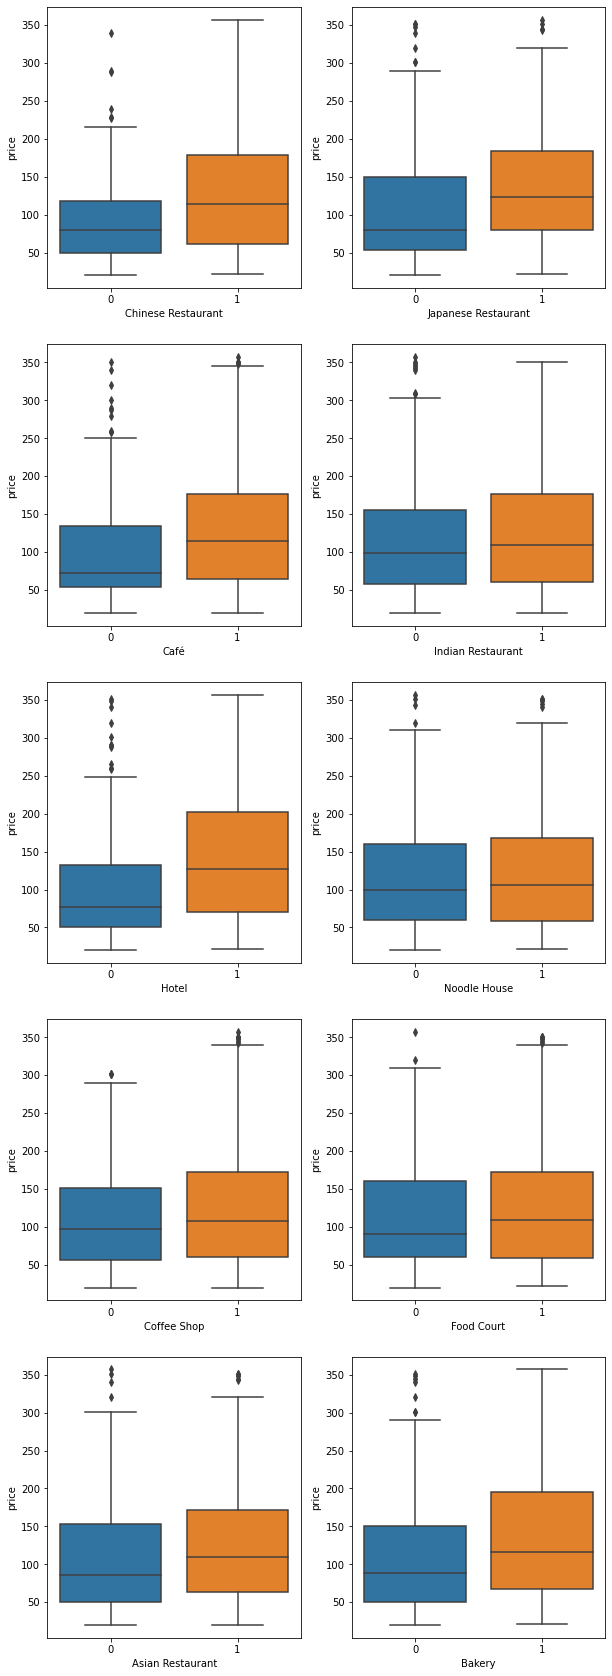

In [434]:
fig, axes = plt.subplots(5, 2, figsize = (10, 30))
for i, venue_name in enumerate(top10_venues_name):
    sns.boxplot(ax = axes[i%5, i//5], x = venue_name, y = 'price', data = listing_merged)
plt.show()

We can see that listing that have these venue have a bit higher price.

In [445]:
# Statistical Analysis - T-test to check significance between two category
import scipy
for venue_name in top10_venues_name :
    p_value = scipy.stats.ttest_ind(
        listing_merged[listing_merged[venue_name] == 1]['price'],
        listing_merged[listing_merged[venue_name] == 0]['price']
    )
    print('{} : \n {}'.format(venue_name, p_value))

Chinese Restaurant : 
 Ttest_indResult(statistic=4.325667180000347, pvalue=1.8381298981795707e-05)
Café : 
 Ttest_indResult(statistic=3.42758435055462, pvalue=0.0006594230191523944)
Hotel : 
 Ttest_indResult(statistic=6.046405621885406, pvalue=2.9085345522341854e-09)
Coffee Shop : 
 Ttest_indResult(statistic=1.5992506862334304, pvalue=0.11039911971265894)
Asian Restaurant : 
 Ttest_indResult(statistic=1.475682334525092, pvalue=0.14066115903107795)
Japanese Restaurant : 
 Ttest_indResult(statistic=3.7589351288673813, pvalue=0.00019086855478341107)
Indian Restaurant : 
 Ttest_indResult(statistic=1.096753303062081, pvalue=0.2732793010001082)
Noodle House : 
 Ttest_indResult(statistic=-0.00406105497319366, pvalue=0.9967613820799148)
Food Court : 
 Ttest_indResult(statistic=1.0809802186462913, pvalue=0.28022910705255316)
Bakery : 
 Ttest_indResult(statistic=3.0173597519985145, pvalue=0.002680372862589289)


We can see that some of these variables are actually insignificant. We can drop these features with p-value > 0.05.

# Let's do machine learning with these new features

In [438]:
df3 = listing_merged.copy()

In [439]:
df3.head()

price       property_type        room_type  listing_duration  \
id                                                                       
26056791     56           Apartment     Private room             357.0   
25980709    250           Apartment  Entire home/apt               0.0   
11283882    301  Serviced apartment  Entire home/apt              45.0   
29307578    278         Condominium  Entire home/apt             237.0   
6352827      50           Apartment     Private room             839.0   

          hosting_duration  calculated_host_listings_count  guests_included  \
id                                                                            
26056791            2504.0                               9                1   
25980709             694.0                               6                4   
11283882             978.0                             193                4   
29307578             298.0                               5                5   
6352827             1498.0                              12                2   

          extra_people  availability_365  availability_60  total_amenities  \
id                                                                           
26056791             0               147               38               15   
25980709            30                 2                1               16   
11283882            30               201                4               31   
29307578            42               299               24               18   
6352827             25                75               44               14   

          Pool  Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                          
26056791     0                    0      0   0          0               0   
25980709     1                    0      0   1          0               0   
11283882     1                    1      1   1          0               1   
29307578     0                    0      1   1          0               0   
6352827      0                    1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights neighbourhood_group_cleansed  number_of_reviews_ltm  \
id                                                                             
26056791            1125               Central Region                     41   
25980709            1125               Central Region                      1   
11283882             800            

In [440]:
dummy_variables = pd.get_dummies(df3[['neighbourhood_group_cleansed', 'property_type', 'room_type']])
df3 = pd.concat([df3, dummy_variables], axis=1)
df3.drop(['neighbourhood_group_cleansed', 'property_type', 'room_type'], axis=1, inplace = True)
df3.head()

price  listing_duration  hosting_duration  \
id                                                    
26056791     56             357.0            2504.0   
25980709    250               0.0             694.0   
11283882    301              45.0             978.0   
29307578    278             237.0             298.0   
6352827      50             839.0            1498.0   

          calculated_host_listings_count  guests_included  extra_people  \
id                                                                        
26056791                               9                1             0   
25980709                               6                4            30   
11283882                             193                4            30   
29307578                               5                5            42   
6352827                               12                2            25   

          availability_365  availability_60  total_amenities  Pool  \
id                                                                   
26056791               147               38               15     0   
25980709                 2                1               16     1   
11283882               201                4               31     1   
29307578               299               24               18     0   
6352827                 75               44               14     0   

          Family/kid friendly  Dryer  TV  Breakfast  Smoke detector  \
id                                                                    
26056791                    0      0   0          0               0   
25980709                    0      0   1          0               0   
11283882                    1      1   1          0               1   
29307578                    0      1   1          0               0   
6352827                     1      1   1          0               0   

          Free parking on premises  Paid parking on premises  Essentials  \
id                                                                         
26056791                         0                         0           1   
25980709                         0                         0           1   
11283882                         1                         0           1   
29307578                         0                         0           1   
6352827                          0                         0           1   

          Pets allowed  Shampoo  Gym  Suitable for events  \
id                                                          
26056791             0        1    0                    0   
25980709             0        1    0                    0   
11283882             0        1    1                    0   
29307578             0        1    0                    0   
6352827              0        1    0                    0   

          Free street parking  Laptop friendly workspace  minimum_nights  \
id                                                                         
26056791                    0                          1               1   
25980709                    0                          0               5   
11283882                    0                          1               7   
29307578                    0                          1               2   
6352827                     0                          0               2   

          maximum_nights  number_of_reviews_ltm  reviews_per_month  \
id                                                                   
26056791            1125                     41               3.40   
25980709            1125                      1               0.21   
11283882             800                      0               0.05   
29307578            1125                     27               3.28   
6352827             1125                     39               3.33   

          review_scores_location  review_scores_cleanliness  \
id                                                           

In [441]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

y = df3['price'] # Target
X = df3.drop(['price', 'latitude', 'longitude'], axis = 1) # Predictors

# Standardize
scaler = StandardScaler()

X_train_o, X_test_o, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)

X_train = scaler.fit_transform(X_train_o)
X_test = scaler.transform(X_test_o)

In [442]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("rf score : {}".format(rf.score(X_test, y_test)))
print("rf test MSE : {}".format(mean_squared_error(rf.predict(X_test), y_test)))

rf score : 0.6408664524180367
rf test MSE : 2128.694176


Not as good as I expected!

Well, let's compare to one without location data.

The one without using location data has score of 62 %. On the other hand, after extracting common venues data, we get a score of 64 %. We still get a score improvement of 2%. That means that our new model can predict the variance of price 2% better than previous model.

Now, this is true if we only use 500 data samples. In the future, I expect that the improvement can be seen even if we use all the dataset (~4600 data) given enough resources and time.

# Conclusion

By scraping venues data from Foursquare API and extracting the common venues, we can improve the sample dataset (500 sample) from 62% to 64%. That implies that spatial features does indeed have an effect to listing price.

**Foreword from Author:**

In the end, an improvement is still an improvement. The author is happy enough that the author can learn a lot in this course. 